<a href="https://www.kaggle.com/code/rubanzasilva/s5e7-fastai-gradient-boosting?scriptVersionId=250743400" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Personality Type Binary Classification

Our goal for this competition is to predict whether a person is an Introvert or Extrovert, given their social behavior and personality traits.

## Data & Library Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv
/kaggle/input/extrovert-vs-introvert-behavior-data/personality_datasert.csv
/kaggle/input/extrovert-vs-introvert-behavior-data/personality_dataset.csv


In [2]:
%%time
%pip install catboost
%pip install optuna
#%pip install optuna_distributed
#%pip install openfe
%pip install seaborn
%pip install xgboost
%pip install lightgbm
%pip install fastkaggle
#%pip install h2o
%pip install -Uqq fastbook
#%pip install polars
%pip install -q -U autogluon.tabular
%pip install autogluon
%pip install --upgrade pip
%pip install tqdm
#%pip install wandb
#%pip install sweetviz

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 542.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.1/124.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.9/246.9 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random
from tqdm import tqdm

#import fastbook
#fastbook.setup_book()
#from fastbook import *
from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random
from tqdm import tqdm
from ipywidgets import interact

from fastai.imports import *
np.set_printoptions(linewidth=130)


from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier,StackingClassifier
#from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold,StratifiedKFold, cross_val_score,train_test_split,GridSearchCV


from pathlib import Path
import os

import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier

import lightgbm as lgb
from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier,Pool, metrics, cv


import warnings


#from openfe import OpenFE, transform
#from autogluon.tabular import TabularDataset, TabularPredictor

#import h2o
#from h2o.automl import H2OAutoML

import gc

import optuna
from optuna.samplers import TPESampler

import pickle
from joblib import dump, load
#import sweetviz as sv
#from IPython.display import FileLink

#import h2o
#from h2o.automl import H2OAutoML

In [4]:
#torch.manual_seed(42)

In [5]:
path = Path('/kaggle/input/playground-series-s5e7/')
path

Path('/kaggle/input/playground-series-s5e7')

In [6]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv')
#original_df = pd.read_csv('/kaggle/input/depression-surveydataset-for-analysis/final_depression_dataset_1.csv')

In [7]:
#train_df.shape,original_df.shape

In [8]:
#train_df = pd.concat([train_df, original_df], ignore_index=True)

## Exploratory Data Analysis

In [9]:
train_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
id,,,,,,,,
0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


## Data Pre-processing with fast.ai

The `RandomSplitter` function below separates the training set into a training and validation set based on the value of the argument `valid_pct`.

In [10]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

In [11]:
#I decided to put concat the original df and the train df after doing the split so that validation can be done on the competition dataset only.
#train_df = pd.concat([train_df, original_df], ignore_index=True)
#train_df = pd.concat(objs=[train_df, original_df])

Below, we are going to prepare our data for machine learning.

First, we define the categorical and continuous variables. I use the fastai `cont_cat_split` function to separate my dataset variables into categorical and continuous variables based on the cardinality of my column values.

`cont_cat_split` takes an argument,`max_card` whose default value is 20. If the number of unique values is above 20 (the default `max_card` value) for a particular column, that column is considered continuous, and vice versa.

Define a `TabularPandas` object. Here we define the continuous and categorical columns, the dataset splitting strategy, preprocessing steps to apply to our datasets, the dependent variable, which is what we are predicting, and the type of problem we are optimizing for, such as binary classification in this case.

I then create and define a `dataloaders` object, which prepares the data for input into our neural network. Here, we also define our batch size.

In [12]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Personality')
#splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
#to = TabularPandas(train_df, procs=[Categorify,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Personality',
                   y_block=CategoryBlock(),
                   splits=splits)
dls = to.dataloaders(bs=64)
#dls = to.dataloaders(bs=1024)
test_dl = dls.test_dl(test_df)

/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

Finally, I extract the training and validation sets plus their values.

In [13]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

### Define Model Parameters

In [14]:
xgb_params = {'seed':42}
lgbm_params = {'seed':42}
cat_params = {'random_seed':42}
rf_params = {'random_state':42}

#### Cross Validation Function

In [15]:
def cross_val_predict(model_class, model_params=None, n_splits=5, random_state=42):
    if model_params is None:
        model_params = {}
    """
    Perform cross-validation using the fixed dataset and return predictions and scores.
    
    Parameters:
    - model_class: the model class (e.g., xgb.XGBClassifier)
    - model_params: dictionary of model parameters
    - n_splits: number of CV folds
    - random_state: random seed for reproducibility
    
    Returns:
    - oof_predictions: out-of-fold predictions on training set
    - submission_predictions: predictions on test_dl.xs
    - mean_score: mean accuracy score across folds
    - fold_scores: list of scores for each fold
    """
    
    # Initialize stratified k-fold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Initialize arrays to store results
    oof_predictions = np.zeros(len(X_train))  # Array for OOF predictions
    submission_predictions = np.zeros(len(test_dl.xs))  # Array for test predictions
    fold_scores = []
    
    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
        # Split data for current fold
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        # Initialize and train model on current fold
        model_fold = model_class(**model_params)
        model_fold.fit(X_fold_train, y_fold_train)
        
        # Get predictions
        y_pred_fold = model_fold.predict(X_fold_val)
        
        # Store OOF predictions
        oof_predictions[val_index] = y_pred_fold
        
        # Get and accumulate test predictions
        submission_predictions += model_fold.predict(test_dl.xs) / n_splits
        
        # Calculate and store score
        cv_score = accuracy_score(y_fold_val, y_pred_fold)
        #cv_score = score(y_fold_val, y_pred_fold)
        fold_scores.append(cv_score)
        
        print(f"Fold {fold} AUC: {cv_score:.6f}")
    
    # Calculate mean score
    mean_score = np.mean(fold_scores)
    print(f"\nMean AUC: {mean_score:.6f}")
    
    return oof_predictions, submission_predictions, mean_score, fold_scores

# Usage example:
#oof_preds, submission_preds, mean_score, fold_scores = cross_val_predict(
    #model_class=xgb.XGBClassifier
#)

# Create submission file
#submission_df = pd.DataFrame({
    #'id': test_df.index,  # adjust if you have different id column
    #'Depression': submission_preds
#})
#submission_df.to_csv('submission.csv', index=False)

# You can also analyze OOF predictions
#print("\nOOF Predictions Score:", accuracy_score(y_train, oof_preds))

## Deep learning - Neural Networks¶

In [16]:
learn = tabular_learner(dls, metrics=accuracy)

SuggestedLRs(valley=0.0010000000474974513)

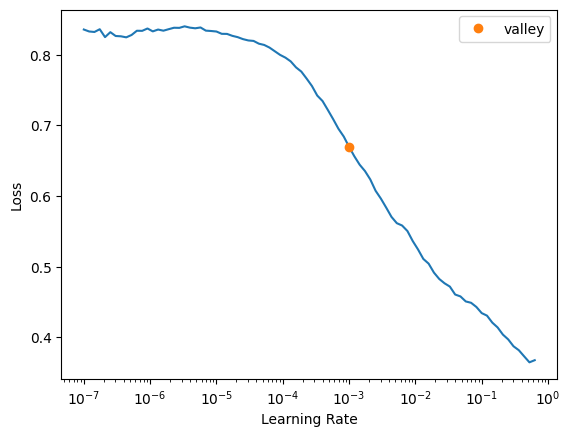

In [17]:
learn.lr_find()

In [18]:
learn.fit_one_cycle(30, 1.089e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.247144,0.216779,0.965983,00:02
1,0.197476,0.197136,0.967333,00:02
2,0.177121,0.164393,0.967873,00:02
3,0.148547,0.141698,0.968683,00:01
4,0.145789,0.136955,0.967603,00:02
5,0.123978,0.139842,0.967873,00:02
6,0.132020,0.129655,0.968952,00:02
7,0.123705,0.128772,0.968952,00:02
8,0.134030,0.133223,0.968952,00:02
9,0.135589,0.132965,0.968143,00:02


In [19]:
dl = test_dl

In [20]:
learn.save('nn_pnality_tp_pd')

Path('models/nn_pnality_tp_pd.pth')

In [21]:
#learn.load('nn_pnality_tp_pd')  

In [22]:
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)
nn_preds_proba = (a_preds[:, 1])

In [23]:
a_preds.shape

torch.Size([6175, 2])

In [24]:
nn_preds_y.shape,sub_df.shape

(torch.Size([6175, 2]), (6175, 2))

In [25]:
nn_preds_x

tensor([[0.1007, 0.8993],
        [0.9426, 0.0574],
        [0.9964, 0.0036],
        ...,
        [0.9655, 0.0345],
        [0.0268, 0.9732],
        [0.9769, 0.0231]])

In [26]:
nn_preds_y

tensor([[0.9968, 0.0032],
        [0.0203, 0.9797],
        [0.9837, 0.0163],
        ...,
        [0.9965, 0.0035],
        [0.9941, 0.0059],
        [0.0198, 0.9802]])

In [27]:
final_preds = torch.round(a_preds).long()
final_preds = final_preds[:,1]
final_preds

tensor([0, 1, 0,  ..., 0, 0, 1])

In [28]:
final_preds.shape

torch.Size([6175])

In [29]:
mapping = dict(enumerate(dls.vocab))
mapping

{0: 'Extrovert', 1: 'Introvert'}

In [30]:
mapping = dict(enumerate(dls.vocab))
submit = pd.read_csv(path/'sample_submission.csv')
submit['Personality'] = [mapping[pred.item()] for pred in final_preds]
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv', index_col='id')
print(sub)

      Personality
id               
18524   Extrovert
18525   Introvert
18526   Extrovert
18527   Extrovert
18528   Introvert
...           ...
24694   Extrovert
24695   Introvert
24696   Extrovert
24697   Extrovert
24698   Introvert

[6175 rows x 1 columns]


In [31]:
#!rm submission.csv
#sub_df['Personality'] = final_preds
#sub_df.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv', index_col='Id')
#sub

## Gradient Boosting

### Random Forest

In [32]:
%%time
rf = RandomForestClassifier(1000, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))
rf_preds_x = tensor(rf_model.predict(X_test))

rf_score = accuracy_score(y_test,rf_preds_x)
rf_score

CPU times: user 9.4 s, sys: 73.9 ms, total: 9.48 s
Wall time: 9.47 s


0.968682505399568

In [33]:
rf_preds

tensor([0, 1, 0,  ..., 0, 0, 1], dtype=torch.int8)

In [34]:
rf_oof_preds, rf_submission_preds, rf_mean_score, rf_fold_scores = cross_val_predict(
    model_class=RandomForestClassifier
)

Fold 1 AUC: 0.967611
Fold 2 AUC: 0.964575
Fold 3 AUC: 0.973009
Fold 4 AUC: 0.969636
Fold 5 AUC: 0.965587

Mean AUC: 0.968084


In [35]:
rf_oof_preds

array([0., 0., 0., ..., 0., 0., 0.])

In [36]:
rf_submission_preds = torch.round(torch.tensor(rf_submission_preds)).long()
rf_submission_preds

tensor([0, 1, 0,  ..., 0, 0, 1])

In [37]:
 rf_mean_score

0.9680836707152498

In [38]:
rf_fold_scores

[0.9676113360323887,
 0.9645748987854251,
 0.9730094466936572,
 0.9696356275303644,
 0.9655870445344129]

In [39]:
rf_oof_preds.shape, rf_submission_preds.shape, rf_mean_score

((14820,), torch.Size([6175]), 0.9680836707152498)

#### Random forest feature importance

In [40]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=True)

In [41]:
fi = rf_feat_importance(rf_model, X_train)
#fi[:10]
fi

,cols,imp
5,Friends_circle_size_na,0.000628
4,Going_outside_na,0.000704
3,Social_event_attendance_na,0.001125
6,Post_frequency_na,0.001135
2,Time_spent_Alone_na,0.001161
10,Friends_circle_size,0.043243
11,Post_frequency,0.105355
9,Going_outside,0.106783
8,Social_event_attendance,0.115215
7,Time_spent_Alone,0.182789


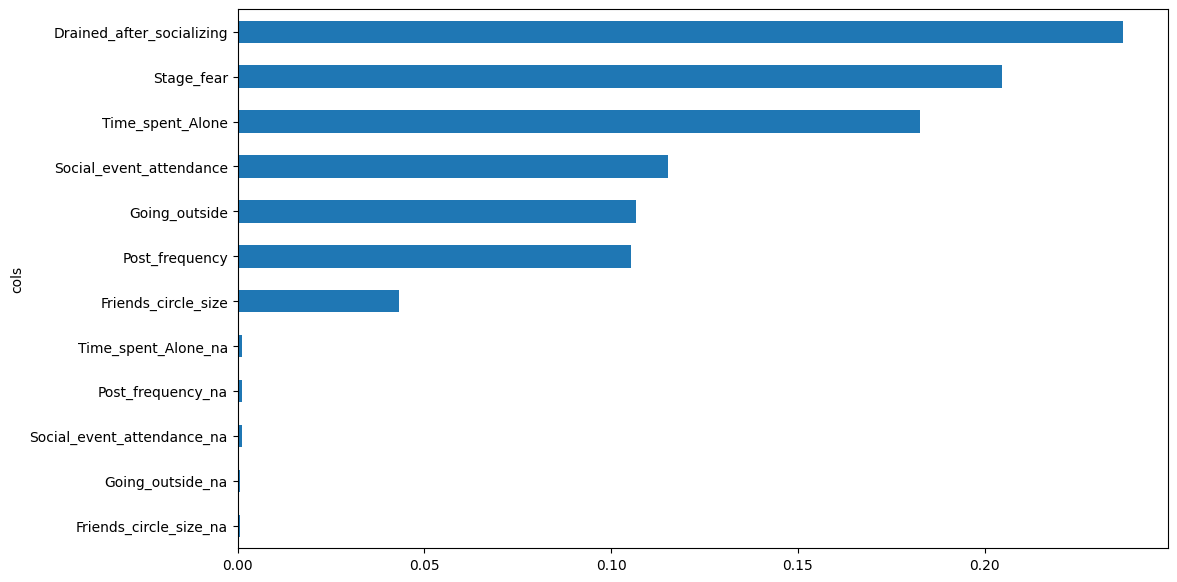

In [42]:
#feature importance visualization
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

#plot_fi(fi[:30]);
plot_fi(fi);

In [43]:
#!rm submission.csv
#mapping = dict(enumerate(dls.vocab))
#submit = pd.read_csv(path/'sample_submission.csv')
#submit['Personality'] = [mapping[pred.item()] for pred in rf_preds]
#submit.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv', index_col='id')
#print(sub)

### XGBoost

##### Single Fold¶

In [44]:
%%time
xgb_model = xgb.XGBClassifier()
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

xgb_score = accuracy_score(y_test,xgb_preds_x)
xgb_score

CPU times: user 233 ms, sys: 11.9 ms, total: 245 ms
Wall time: 142 ms


0.9681425485961123

In [45]:
xgb_oof_preds, xgb_submission_preds, xgb_mean_score, xgb_fold_scores = cross_val_predict(
    model_class=xgb.XGBClassifier
)

Fold 1 AUC: 0.967274
Fold 2 AUC: 0.963563
Fold 3 AUC: 0.971660
Fold 4 AUC: 0.968286
Fold 5 AUC: 0.964912

Mean AUC: 0.967139


In [46]:
xgb_oof_preds

array([0., 0., 0., ..., 0., 0., 0.])

In [47]:
xgb_submission_preds = torch.round(torch.tensor(xgb_submission_preds)).long()
xgb_submission_preds

tensor([0, 1, 0,  ..., 0, 0, 1])

In [48]:
xgb_mean_score,xgb_fold_scores

(0.9671390013495277,
 [0.9672739541160594,
  0.9635627530364372,
  0.97165991902834,
  0.9682860998650472,
  0.9649122807017544])

In [49]:
xgb_oof_preds.shape, xgb_submission_preds.shape, xgb_mean_score
#fold_scores.shape

((14820,), torch.Size([6175]), 0.9671390013495277)

In [50]:
#!rm submission.csv
##mapping = dict(enumerate(dls.vocab))
#submit = pd.read_csv(path/'sample_submission.csv')
#submit['Personality'] = [mapping[pred.item()] for pred in xgb_preds]
#submit.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv', index_col='id')
#print(sub)

### LGBM

In [51]:
%%time
#ds subset
lgbm_model = lgb.LGBMClassifier()
lgbm_model = lgbm_model.fit(X_train, y_train)

#test set preds
#lgbm_preds = tensor(lgbm_model.predict(test_dl.xs))
lgbm_preds = tensor(lgbm_model.predict(test_dl.xs))

lgbm_preds_x = tensor(lgbm_model.predict(X_test))

lgbm_score = accuracy_score(y_test,lgbm_preds_x)
lgbm_score

[LightGBM] [Info] Number of positive: 3878, number of negative: 10942
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 14820, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.261673 -> initscore=-1.037289
[LightGBM] [Info] Start training from score -1.037289
CPU times: user 284 ms, sys: 22 ms, total: 306 ms
Wall time: 183 ms


0.968682505399568

In [52]:
lgbm_oof_preds, lgbm_submission_preds, lgbm_mean_score, lgbm_fold_scores = cross_val_predict(
    model_class=lgb.LGBMClassifier
)

[LightGBM] [Info] Number of positive: 3103, number of negative: 8753
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 11856, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.261724 -> initscore=-1.037027
[LightGBM] [Info] Start training from score -1.037027
Fold 1 AUC: 0.968286
[LightGBM] [Info] Number of positive: 3103, number of negative: 8753
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 11856, number of used features: 12
[Ligh

In [53]:
lgbm_oof_preds

array([0., 0., 0., ..., 0., 0., 0.])

In [54]:
lgbm_submission_preds = torch.round(torch.tensor(lgbm_submission_preds)).long()
lgbm_submission_preds

tensor([0, 1, 0,  ..., 0, 0, 1])

In [55]:
lgbm_mean_score,lgbm_fold_scores

(0.9685560053981106,
 [0.9682860998650472,
  0.9659244264507423,
  0.9723346828609987,
  0.9689608636977058,
  0.9672739541160594])

In [56]:
lgbm_oof_preds.shape, lgbm_submission_preds.shape, lgbm_mean_score

((14820,), torch.Size([6175]), 0.9685560053981106)

In [57]:
%%time
K_FOLDS = 10
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
lgb_fold_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    
    lgb_model_fold = lgb.LGBMClassifier()
    lgb_model_fold.fit(X_fold_train, y_fold_train)
    
    # Predict on validation set
    y_pred_fold = lgb_model_fold.predict(X_fold_val)
    y_pred_fold_tt = lgb_model_fold.predict(test_dl.xs)
    
    # Calculate accuracy score
    lgb_cv_score = accuracy_score(y_fold_val, lgb_model_fold.predict(X_fold_val))
    lgb_fold_scores.append(lgb_cv_score)
    
    print(f"Fold {fold} AUC: {lgb_cv_score}")

lgb_mean_score = np.mean(lgb_fold_scores)
print(f"Mean AUC: {lgb_mean_score}")

[LightGBM] [Info] Number of positive: 3491, number of negative: 9847
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 13338, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.261733 -> initscore=-1.036979
[LightGBM] [Info] Start training from score -1.036979
Fold 1 AUC: 0.9743589743589743
[LightGBM] [Info] Number of positive: 3491, number of negative: 9847
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 13338, number of used features

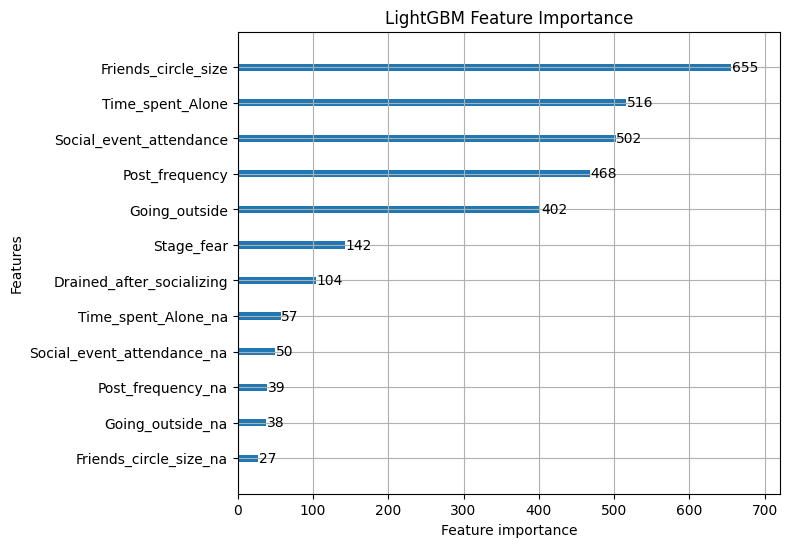

In [58]:
# Plot feature importance without using Gain or split
lgb.plot_importance(lgbm_model, figsize=(7,6), title="LightGBM Feature Importance")
#plt.title('LGBM Feature Importance')
#plt.tight_layout()
plt.show()

In [59]:
#!rm submission.csv
#mapping = dict(enumerate(dls.vocab))
#submit = pd.read_csv(path/'sample_submission.csv')
#submit['Personality'] = [mapping[pred.item()] for pred in lgbm_preds]
#submit.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv', index_col='id')
#print(sub)

### CatBoost

In [60]:
%%time
#using full ds
cat_model_params = CatBoostClassifier()
cat_model_params = cat_model_params.fit(X_train, y_train, verbose=False)


cat_preds_params = tensor(cat_model_params.predict(test_dl.xs))

cat_preds_x_params = tensor(cat_model_params.predict(X_test))

cat_score_params = accuracy_score(y_test,cat_preds_x_params)
cat_score_params

CPU times: user 12.2 s, sys: 2.37 s, total: 14.6 s
Wall time: 3.93 s


0.9670626349892009

In [61]:
%%time
#using full ds
cat_model = CatBoostClassifier()
cat_model = cat_model.fit(X_train, y_train, verbose=False)


cat_preds = tensor(cat_model.predict(test_dl.xs))

cat_preds_x = tensor(cat_model.predict(X_test))

cat_score = accuracy_score(y_test,cat_preds_x)
cat_score

CPU times: user 11.8 s, sys: 2.09 s, total: 13.9 s
Wall time: 3.51 s


0.9670626349892009

In [62]:
cat_oof_preds_y, cat_submission_preds_y, cat_mean_score_y, cat_fold_scores_y = cross_val_predict(
    model_class=CatBoostClassifier,
    
)

Learning rate set to 0.029615
0:	learn: 0.6446037	total: 4.3ms	remaining: 4.3s
1:	learn: 0.6013323	total: 7.33ms	remaining: 3.66s
2:	learn: 0.5612936	total: 10.7ms	remaining: 3.56s
3:	learn: 0.5237962	total: 13.9ms	remaining: 3.45s
4:	learn: 0.4901920	total: 17.2ms	remaining: 3.43s
5:	learn: 0.4595949	total: 20.4ms	remaining: 3.38s
6:	learn: 0.4314583	total: 23.3ms	remaining: 3.31s
7:	learn: 0.4059707	total: 26.2ms	remaining: 3.25s
8:	learn: 0.3827068	total: 30ms	remaining: 3.31s
9:	learn: 0.3622180	total: 33.2ms	remaining: 3.29s
10:	learn: 0.3430160	total: 36.5ms	remaining: 3.28s
11:	learn: 0.3256287	total: 39.7ms	remaining: 3.27s
12:	learn: 0.3096942	total: 42.8ms	remaining: 3.25s
13:	learn: 0.2947855	total: 46.1ms	remaining: 3.24s
14:	learn: 0.2823123	total: 48.5ms	remaining: 3.19s
15:	learn: 0.2703406	total: 51.6ms	remaining: 3.17s
16:	learn: 0.2587911	total: 54.6ms	remaining: 3.15s
17:	learn: 0.2493889	total: 56.8ms	remaining: 3.1s
18:	learn: 0.2399029	total: 59.8ms	remaining: 3.0

In [63]:
cat_score_params,cat_score

(0.9670626349892009, 0.9670626349892009)

In [64]:
cat_oof_preds, cat_submission_preds, cat_mean_score, cat_fold_scores = cross_val_predict(
    model_class=CatBoostClassifier
)

Learning rate set to 0.029615
0:	learn: 0.6446037	total: 4.48ms	remaining: 4.47s
1:	learn: 0.6013323	total: 7.22ms	remaining: 3.6s
2:	learn: 0.5612936	total: 10.2ms	remaining: 3.4s
3:	learn: 0.5237962	total: 13.4ms	remaining: 3.34s
4:	learn: 0.4901920	total: 16.4ms	remaining: 3.26s
5:	learn: 0.4595949	total: 19.4ms	remaining: 3.21s
6:	learn: 0.4314583	total: 22.4ms	remaining: 3.18s
7:	learn: 0.4059707	total: 25.1ms	remaining: 3.12s
8:	learn: 0.3827068	total: 28.1ms	remaining: 3.09s
9:	learn: 0.3622180	total: 31.2ms	remaining: 3.09s
10:	learn: 0.3430160	total: 34.3ms	remaining: 3.08s
11:	learn: 0.3256287	total: 37.1ms	remaining: 3.06s
12:	learn: 0.3096942	total: 40.3ms	remaining: 3.06s
13:	learn: 0.2947855	total: 43.5ms	remaining: 3.06s
14:	learn: 0.2823123	total: 45.8ms	remaining: 3.01s
15:	learn: 0.2703406	total: 48.8ms	remaining: 3s
16:	learn: 0.2587911	total: 51.8ms	remaining: 2.99s
17:	learn: 0.2493889	total: 54ms	remaining: 2.94s
18:	learn: 0.2399029	total: 57ms	remaining: 2.94s
1

In [65]:
cat_oof_preds

array([0., 0., 0., ..., 0., 0., 0.])

In [66]:
cat_submission_preds = torch.round(torch.tensor(cat_submission_preds)).long()
cat_submission_preds

tensor([0, 1, 0,  ..., 0, 0, 1])

In [67]:
cat_mean_score,cat_mean_score_y

(0.9687584345479081, 0.9687584345479081)

In [68]:
cat_mean_score,cat_mean_score_y

(0.9687584345479081, 0.9687584345479081)

In [69]:
cat_oof_preds.shape, cat_submission_preds.shape, cat_mean_score

((14820,), torch.Size([6175]), 0.9687584345479081)

In [70]:
%%time
K_FOLDS = 10
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
cat_fold_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    
    cat_model_fold = CatBoostClassifier()
    cat_model_fold.fit(X_fold_train, y_fold_train)
    
    # Predict on validation set
    y_pred_fold = cat_model_fold.predict(X_fold_val)
    y_pred_fold_tt = cat_model_fold.predict(test_dl.xs)
    
    # Calculate accuracy score
    cat_cv_score = accuracy_score(y_fold_val, cat_model_fold.predict(X_fold_val))
    cat_fold_scores.append(cat_cv_score)
    
    print(f"Fold {fold} AUC: {cat_cv_score}")

catboost_mean_score = np.mean(cat_fold_scores)
print(f"Mean AUC: {catboost_mean_score}")

Learning rate set to 0.031142
0:	learn: 0.6428835	total: 4.13ms	remaining: 4.12s
1:	learn: 0.5979949	total: 7.17ms	remaining: 3.58s
2:	learn: 0.5569711	total: 10.6ms	remaining: 3.52s
3:	learn: 0.5185035	total: 13.8ms	remaining: 3.44s
4:	learn: 0.4841213	total: 16.5ms	remaining: 3.29s
5:	learn: 0.4531873	total: 20.1ms	remaining: 3.33s
6:	learn: 0.4251838	total: 23.3ms	remaining: 3.31s
7:	learn: 0.3989025	total: 26.7ms	remaining: 3.31s
8:	learn: 0.3758135	total: 29.9ms	remaining: 3.3s
9:	learn: 0.3550476	total: 33.3ms	remaining: 3.3s
10:	learn: 0.3359730	total: 36.1ms	remaining: 3.25s
11:	learn: 0.3185061	total: 39.5ms	remaining: 3.25s
12:	learn: 0.3030760	total: 42.7ms	remaining: 3.24s
13:	learn: 0.2887306	total: 45.8ms	remaining: 3.23s
14:	learn: 0.2764237	total: 48.1ms	remaining: 3.16s
15:	learn: 0.2646680	total: 51.1ms	remaining: 3.14s
16:	learn: 0.2535533	total: 54.3ms	remaining: 3.14s
17:	learn: 0.2437171	total: 57.7ms	remaining: 3.15s
18:	learn: 0.2345382	total: 61ms	remaining: 3.

In [71]:
feature_importance = cat_model.get_feature_importance()
feature_names = train_df.columns

# Display feature importance
for name, importance in zip(feature_names, feature_importance):
    print(f"Feature: {name}, Importance: {importance:.2f}")

Feature: Time_spent_Alone, Importance: 8.03
Feature: Stage_fear, Importance: 7.53
Feature: Social_event_attendance, Importance: 1.95
Feature: Going_outside, Importance: 2.46
Feature: Drained_after_socializing, Importance: 2.06
Feature: Friends_circle_size, Importance: 0.50
Feature: Post_frequency, Importance: 1.35
Feature: Personality, Importance: 14.49


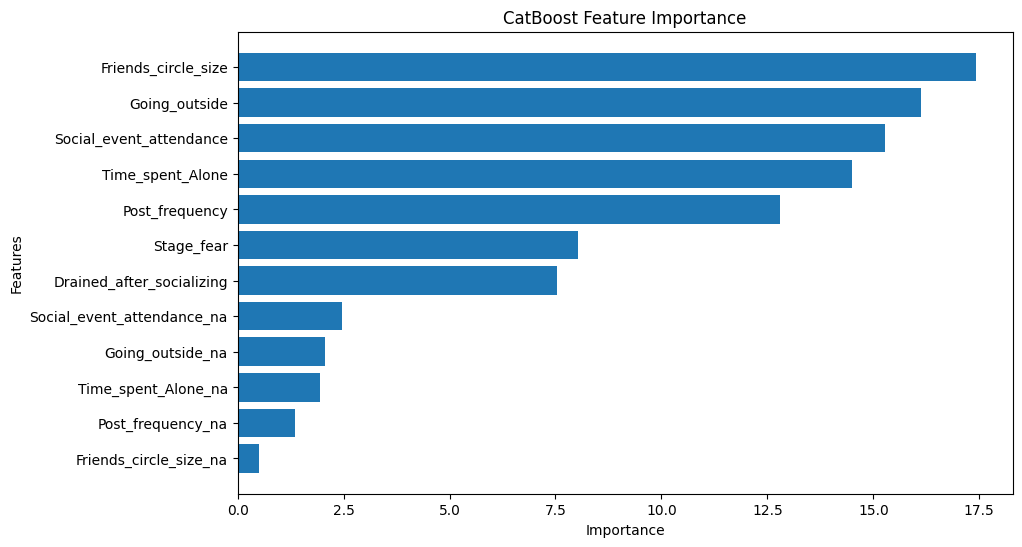

In [72]:
#importances = cat_model.get_feature_importance(type='PredictionValuesChange')
importances = cat_model.get_feature_importance()
feature_importances = pd.Series(importances, index=X_train.columns).sort_values()
plt.figure(figsize=(10, 6))
plt.barh(feature_importances.index, feature_importances.values)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [73]:
#!rm submission.csv
#mapping = dict(enumerate(dls.vocab))
##submit = pd.read_csv(path/'sample_submission.csv')
#submit['Personality'] = [mapping[pred.item()] for pred in cat_preds]
#submit.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv', index_col='id')
#print(sub)

## Ranking

In [74]:
accuracy = pd.DataFrame({
    'algorithm': ['Random Forest',
                  'RF CV','XGBoost','XGBoost CV','LGBM','LGBM CV','CatBoost','CatBoost CV',
                 ],
    'accuracy': [rf_mean_score,rf_score,xgb_score,xgb_mean_score,lgbm_score,
                 lgbm_mean_score,cat_score,cat_mean_score,
           ]
})

accuracy_sorted = accuracy.sort_values(by='accuracy', ascending=False)
accuracy_sorted

,algorithm,accuracy
7,CatBoost CV,0.968758
1,RF CV,0.968683
4,LGBM,0.968683
5,LGBM CV,0.968556
2,XGBoost,0.968143
0,Random Forest,0.968084
3,XGBoost CV,0.967139
6,CatBoost,0.967063
